In [12]:
import pandas as pd
import numpy as np
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow as tf
tf.keras.layers.Dense(100)
from utils.gpu_memory_grow import gpu_memory_grow

import matplotlib.pyplot as plt
import itertools
from models.evaluation import utils
from utils import eval_methods, dataLoader, simple_metric

# from configs.mts_style_transfer_v2.args import DafaultArguments as args
from configs.mts_style_transfer_v2.args_sim import DafaultArguments as args
# from configs.mts_style_transfer_v2.args_real import DafaultArguments as args

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import umap
from sklearn.manifold import TSNE

gpus = tf.config.list_physical_devices('GPU')
gpu_memory_grow(gpus)

In [13]:
MODEL_TO_EVALUATE = "to_evaluate/24-11-26 - LSGAN Previous  + petite modif archi/causal_shift Previous + petite modif archi"

In [14]:
def predictions_on_content_space(content_dset_path:str, content_encoder:tf.keras.Model, data_loading_arguments:dict):

    dset_content_train, dset_content_valid = utils.load_dset(content_dset_path, data_loading_arguments, drop_labels=False)

    dset_content_train= utils.encode_dataset(dset_content_train, content_encoder, data_loading_arguments)
    dset_content_valid= utils.encode_dataset(dset_content_valid, content_encoder, data_loading_arguments)

    content_perf = eval_methods.predictions_on_content_space(dset_content_train, dset_content_valid, data_loading_arguments)

    return content_perf

def load_valid_batches(content_dataset_path:str, style_dataset_path:str):
    default_parameters = args()

    sequence_length = default_parameters.simulated_arguments.sequence_lenght_in_sample
    gran = default_parameters.simulated_arguments.granularity
    overlap = default_parameters.simulated_arguments.overlap
    bs = args().simulated_arguments.batch_size
    
    _, content_dset_valid = dataLoader.loading_wrapper(
        content_dataset_path,
        sequence_length, 
        gran, 
        overlap, 
        bs)
    
    _, style_dset_valid =  dataLoader.loading_wrapper(
        style_dataset_path, 
        sequence_length, 
        gran, 
        overlap,
        bs)
    
    
    content_batch = dataLoader.get_batches(content_dset_valid, 500)
    style_batch = dataLoader.get_batches(style_dset_valid, 500) 
    
    return content_batch, style_batch

def generate(content_batch, style_batch, content_encoder, style_encoder, decoder):
    
    content = content_encoder(content_batch, training=False)
    style = style_encoder(style_batch, training=False)
    generated = decoder([content, style], training=False)
    
    generated = tf.concat(generated, -1)
    
    return generated

# Evaluate Trained Dataset

In [15]:
training_arguments = utils.get_model_training_arguments(MODEL_TO_EVALUATE)
ce, se, de = utils.load_models(MODEL_TO_EVALUATE)

# Generation quality.
## Generate a "dataset" for each style.

In [16]:
def get_name(path:str):
    filename = path.split("/")[-1]
    return ".".join(filename.split('.')[:-1])

In [17]:
def stylize(
        content_dset:tf.data.Dataset, 
        style_sequence:tf.Tensor, 
        content_encoder:tf.keras.Model, 
        style_encoder:tf.keras.Model, 
        decoder:tf.keras.Model, args:dict) -> tf.data.Dataset:

    content_space = content_dset.map(lambda seq, _: (content_encoder(seq)), num_parallel_calls=tf.data.AUTOTUNE).cache()
    labels = content_dset.map(lambda _,l : l, num_parallel_calls=tf.data.AUTOTUNE).cache()
    
    style_vector = style_encoder(style_sequence)

    translated = content_space.map(lambda d1, d2, d3, x : tf.concat(decoder([[d1, d2, d3, x], style_vector], training=False), -1), num_parallel_calls=tf.data.AUTOTUNE).cache()
    dset_final = tf.data.Dataset.zip((translated, labels))

    return dset_final


In [18]:
real_style_dataset = {}
fake_style_dataset = {}
style_names = []
bs = 256 #args().simulated_arguments.batch_size

dset_content_train, dset_content_valid = utils.load_dset(training_arguments["dset_content"], training_arguments, drop_labels=False, bs=bs)

dset_content_train = utils.extract_labels(dset_content_train, training_arguments)
dset_content_valid = utils.extract_labels(dset_content_valid, training_arguments)


for style_path in training_arguments["style_datasets"]:
    sty_name = get_name(style_path)
    style_names.append(sty_name)
    
    print(f"Making {sty_name}")
    
    dset_style_train, dset_style_valid = utils.load_dset(style_path, training_arguments, drop_labels=False, bs=bs)
    
    dset_lstyle_train = utils.extract_labels(dset_style_train, training_arguments)
    dset_lstyle_valid = utils.extract_labels(dset_style_valid, training_arguments)
        
    real_style_dataset[f"{sty_name}_train"] = dset_lstyle_train
    real_style_dataset[f"{sty_name}_valid"] = dset_lstyle_valid
    
    style_batch_train = next(iter(dset_lstyle_train))[0][0]
    style_batch_train = np.array([style_batch_train]* bs)
    
    style_batch_valid = next(iter(dset_lstyle_valid))[0][0]
    style_batch_valid = np.array([style_batch_valid]* bs)
            
    stylized_train = stylize(dset_content_train, style_batch_train, ce, se, de, training_arguments)
    stylized_valid = stylize(dset_content_valid, style_batch_valid, ce, se, de, training_arguments)
    
    fake_style_dataset[f"{sty_name}_train"] = stylized_train
    fake_style_dataset[f"{sty_name}_valid"] = stylized_valid

Making 0.00_standardized
Making 0.10_standardized
Making 0.20_standardized
Making 0.30_standardized
Making 0.40_standardized
Making 0.50_standardized
Making 0.60_standardized
Making 0.70_standardized
Making 0.80_standardized
Making 0.90_standardized


# Some Generations.

2024-12-19 11:47:43.192419: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-19 11:47:43.192528: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-12-19 11:47:43.193522: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. I

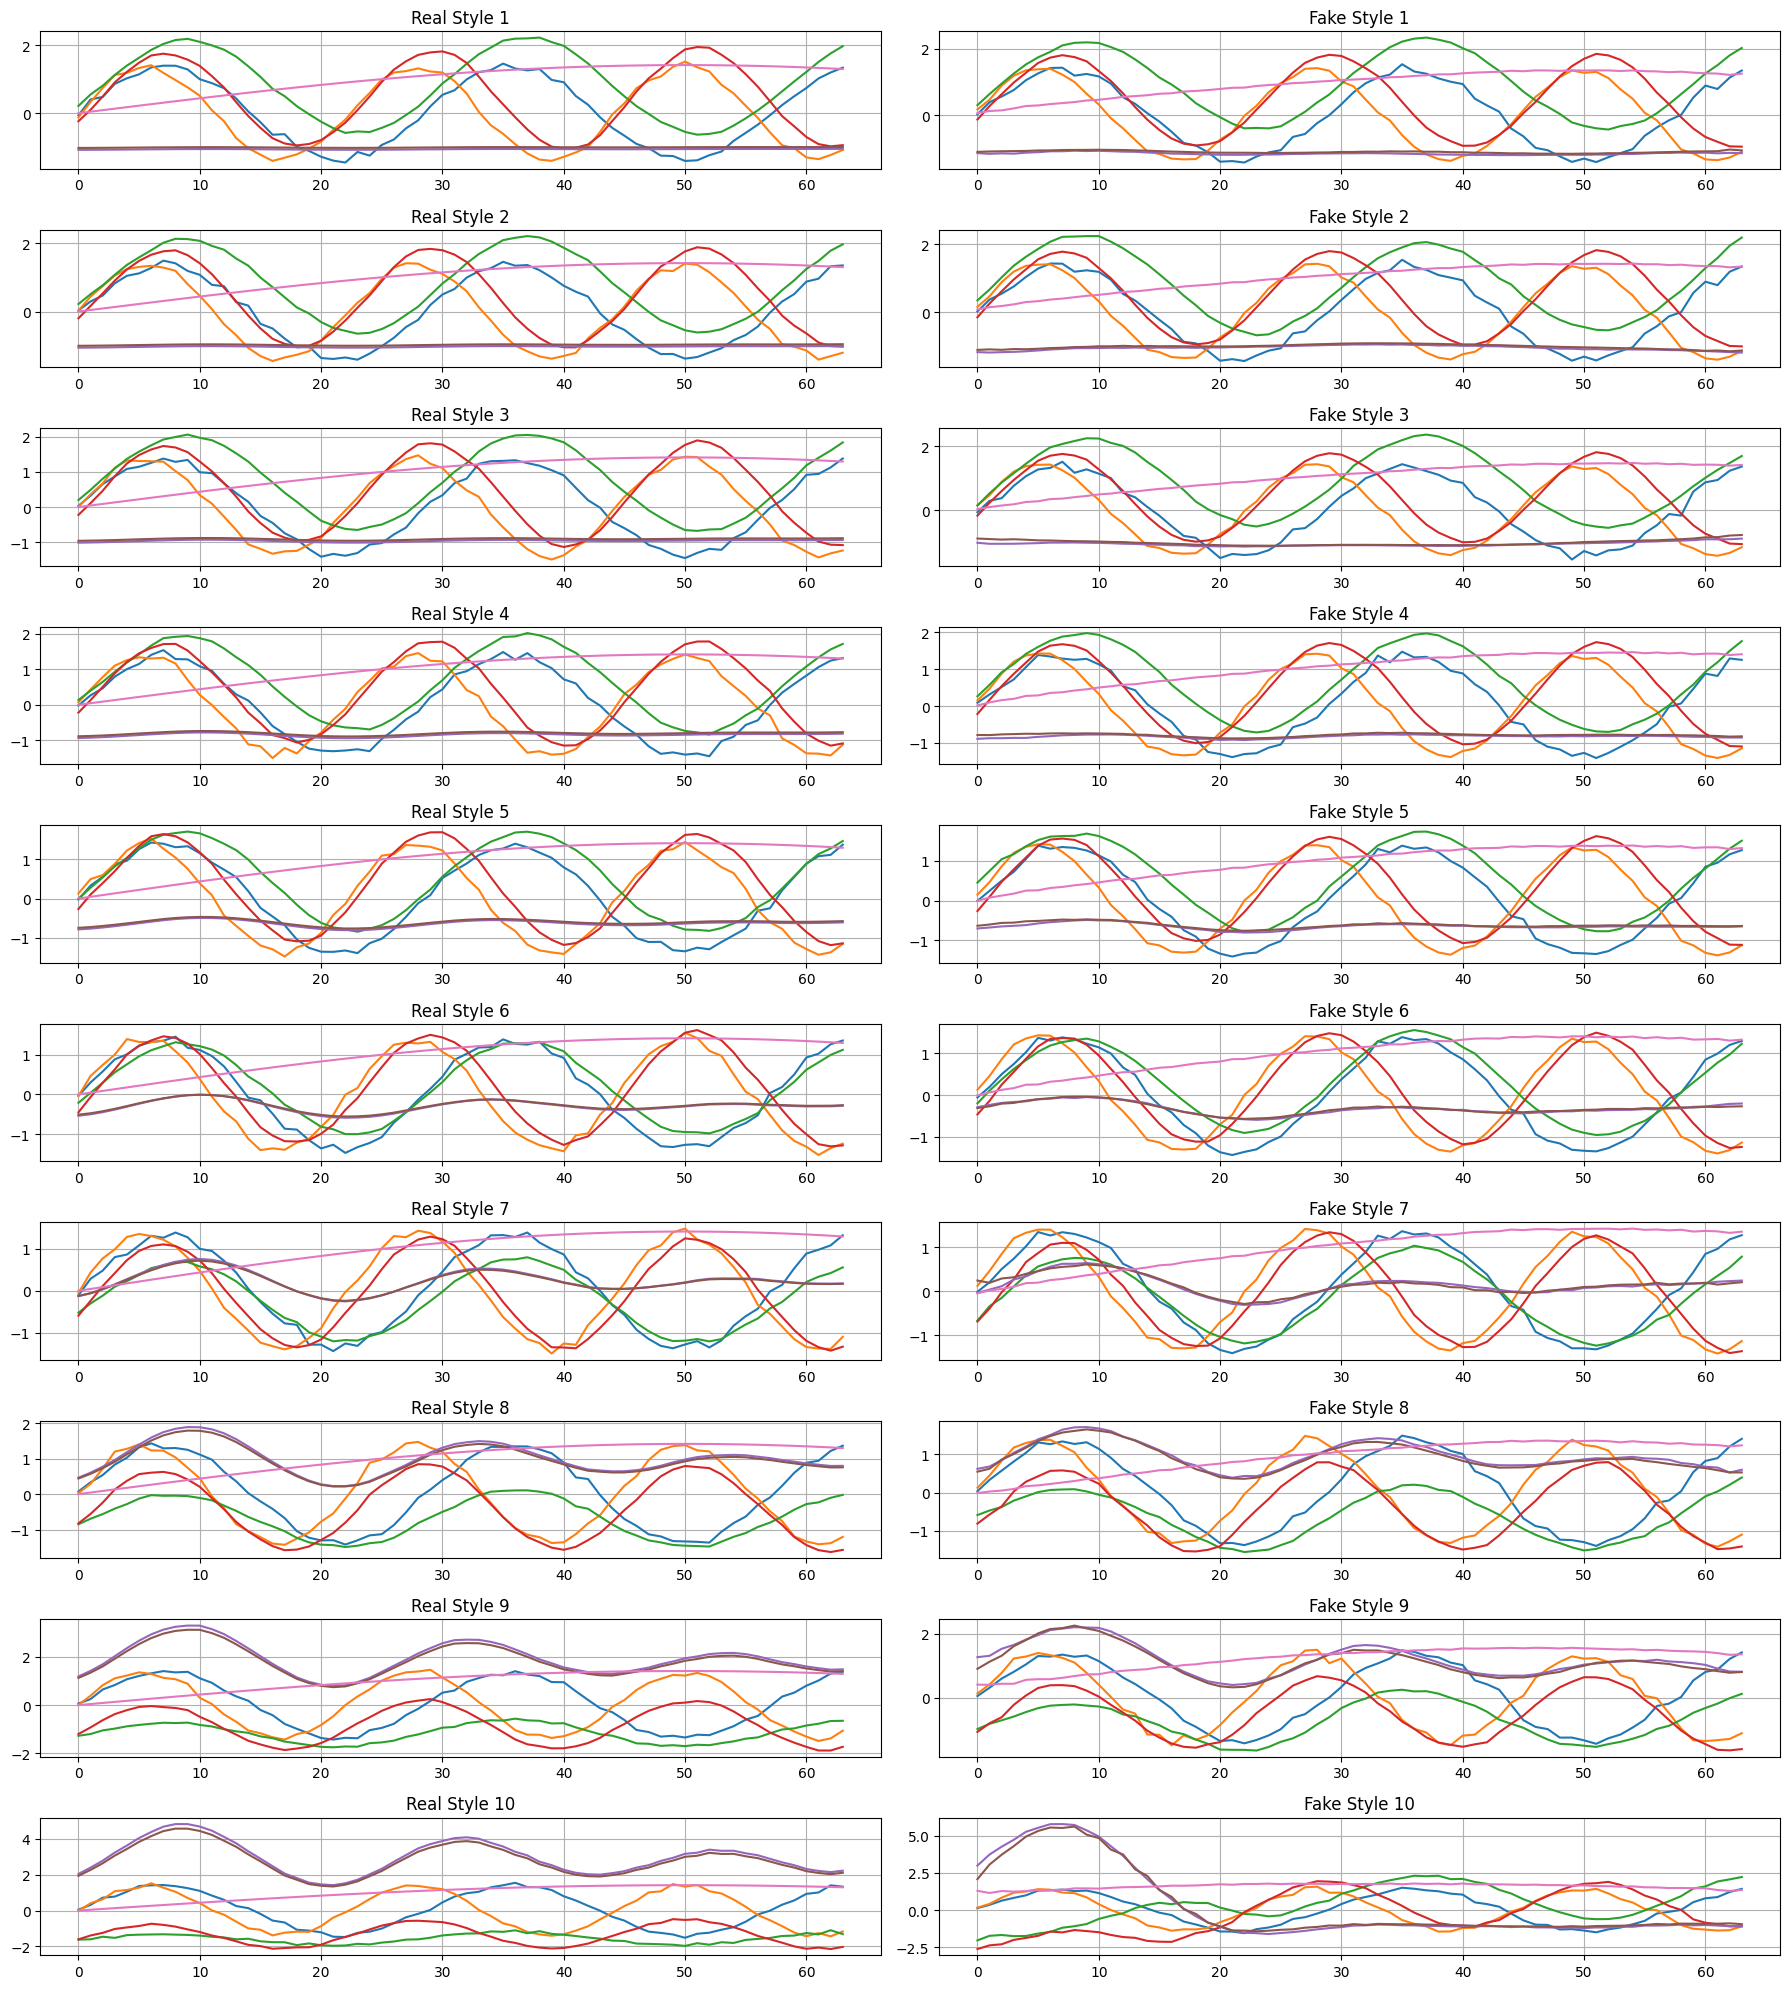

In [19]:
plt.figure(figsize=(18, 20))


for i, style_ in enumerate(style_names):
    real_style_sequence = next(iter(real_style_dataset[f"{style_}_valid"]))[0][0]
    fake_style_sequence = next(iter(fake_style_dataset[f"{style_}_valid"]))[0][0]
    
    
    ax = plt.subplot(len(style_names), 2, 2*i+1)
    ax.set_title(f"Real Style {i+1}")
    plt.plot(real_style_sequence)
    ax.grid(True)
    # ax.set_ylim(-0.01, 20.01)
    
        
    ax = plt.subplot(len(style_names), 2, 2*i+2)
    ax.set_title(f"Fake Style {i+1}")
    
    plt.plot(fake_style_sequence)
    # ax.set_ylim(-0.01, 20.01)
    
    
    ax.grid(True)
    
plt.tight_layout()
plt.savefig(f"{MODEL_TO_EVALUATE}/generations.png")

# TSTR

In [20]:
from models.NaiveClassifier import make_naive_discriminator

def train_naive_discriminator(train_dset, valid_dset, args, epochs, n_classes):
    seq_shape = args.simulated_arguments.seq_shape

    naive_discr = make_naive_discriminator(seq_shape, n_classes)
    history = naive_discr.fit(train_dset, validation_data=valid_dset, epochs=epochs, verbose=0)

    return naive_discr.evaluate(valid_dset)[1], history


    
def tstr(
    dset_train_real,
    dset_valid_real,
    dset_train_fake, 
    dset_valid_fake, 
    save_to:str):

    print('[+] Train Real, Test Real.')
    real_performances, hist_real = train_naive_discriminator(dset_train_real, dset_valid_real, args(), epochs=50, n_classes=5)

    print("[+] Train Synthetic, Test Synthetic")
    gen_perf1, hist_fake1 = eval_methods.train_naive_discriminator(dset_train_fake, dset_valid_fake, args(), epochs=50, n_classes=5)
    
    print("[+] Train Synthetic, Test Real")
    gen_perf2, hist_fake2 = eval_methods.train_naive_discriminator(dset_train_fake, dset_valid_real, args(), epochs=50, n_classes=5)
    
    
    fig = plt.figure(figsize=(18, 10))
    
    ax = plt.subplot(211)
    
    plt.plot(hist_real.history["loss"], ".-", label='Train Real Test Real (Train)')
    plt.plot(hist_real.history["val_loss"], ".-", label='Train Real Test Real (Valid)')
    
    plt.plot(hist_fake1.history["loss"], ".-", label='Train Synthetic, Test Synthetic (Train)')
    plt.plot(hist_fake1.history["val_loss"], ".-", label='Train Synthetic, Test Synthetic (Valid)')
    
    plt.plot(hist_fake2.history["loss"], ".-", label='Train Real, Test Synthetic (Train)')
    plt.plot(hist_fake2.history["val_loss"], ".-", label='Train Real, Test Synthetic (Valid)')
    
    ax.legend()
    ax.grid()
    ax = plt.subplot(212)
    
    plt.plot(hist_real.history["sparse_categorical_accuracy"], ".-", label='Classification Acc on Real (Train)')
    plt.plot(hist_real.history["val_sparse_categorical_accuracy"], ".-", label='Classification Acc on Real (Valid)')
    
    plt.plot(hist_fake1.history["sparse_categorical_accuracy"], ".-", label='Train Synthetic, Test Synthetic (Train)')
    plt.plot(hist_fake1.history["val_sparse_categorical_accuracy"], ".-", label='Train Synthetic, Test Synthetic (Valid)')
    
    plt.plot(hist_fake2.history["sparse_categorical_accuracy"], ".-", label='Train Real, Test Synthetic (Train)')
    plt.plot(hist_fake2.history["val_sparse_categorical_accuracy"], ".-", label='Train Real, Test Synthetic (Valid)')
    
    ax.grid()
    ax.legend()
    
    plt.savefig(save_to)
    plt.show()
    
    plt.close(fig)
    
    return real_performances, gen_perf2

In [21]:
tstr_stats = {}

for i, style_ in enumerate(style_names):
    print(f'[+] Training on dataset {style_}.')
    
    perf_on_real, perf_on_fake = tstr(
        real_style_dataset[f"{style_}_train"],
        real_style_dataset[f"{style_}_valid"],
        fake_style_dataset[f"{style_}_train"],
        fake_style_dataset[f"{style_}_valid"], 
        f'{MODEL_TO_EVALUATE}/tstr_{style_}.png'
        )
    
    tstr_stats[f"{style_}_real"] = [perf_on_real]
    tstr_stats[f"{style_}_gen"] = [perf_on_fake]
    
# tstr_stats = pd.DataFrame.from_dict(tstr_stats)

# tstr_stats.to_hdf(f"{MODEL_TO_EVALUATE}/tstr.h5", key="data")


[+] Training on dataset 0.00_standardized.
[+] Train Real, Test Real.
260/260 [==============================] - 8s 31ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9896
[+] Train Synthetic, Test Synthetic
Epoch 1/50
1041/1041 [==============================] - 79s 75ms/step - loss: 1.5394 - sparse_categorical_accuracy: 0.2935 - val_loss: 1.5369 - val_sparse_categorical_accuracy: 0.2966
Epoch 2/50
1041/1041 [==============================] - 9s 9ms/step - loss: 1.5368 - sparse_categorical_accuracy: 0.2936 - val_loss: 1.5365 - val_sparse_categorical_accuracy: 0.2956
Epoch 3/50
1041/1041 [==============================] - 9s 9ms/step - loss: 1.5365 - sparse_categorical_accuracy: 0.2932 - val_loss: 1.5358 - val_sparse_categorical_accuracy: 0.2900
Epoch 4/50
1041/1041 [==============================] - 9s 9ms/step - loss: 1.5364 - sparse_categorical_accuracy: 0.2932 - val_loss: 1.5363 - val_sparse_categorical_accuracy: 0.2911
Epoch 5/50
1041/1041 [==============================] -

KeyboardInterrupt: 

In [ ]:
# real_columns = [f"{sn}_real" for sn in style_names]
# gen_columns = [f"{sn}_gen" for sn in style_names]

# real_valid_accs = tstr_stats[real_columns].values.reshape((-1,))
# gen_valid_accs = tstr_stats[gen_columns].values.reshape((-1,))


# plt.figure(figsize=(10, 5))
# plt.title("Accuracy of method.")

# plt.plot(real_valid_accs, '.-', label='Train on Real Acc')
# plt.plot(gen_valid_accs, '.-', label='Train on Generated Acc')
# plt.ylim((-0.01, 1.01))
# plt.xticks()
# plt.grid()
# plt.legend()
# plt.savefig(f"{MODEL_TO_EVALUATE}/acc_results.png")
# plt.show()

# UMAP Evaluation

In [ ]:
def get_batches(dset, n_batches):
    _arr = np.array([c[0] for c in dset.take(n_batches)])
    return _arr.reshape((-1, _arr.shape[-2], _arr.shape[-1]))

In [ ]:
# real_batches = []
# fake_batches = []

# for i, style_ in enumerate(style_names):
#     real_style_batch = get_batches(real_style_dataset[f"{style_}_valid"], 10)
#     fake_style_batch = get_batches(fake_style_dataset[f"{style_}_valid"], 10)
    
#     real_batches.append(real_style_batch)
#     fake_batches.append(fake_style_batch)
    
# real_batches = np.array(real_batches)     
# fake_batches = np.array(fake_batches)  

In [ ]:
# def multi_umap_plot(real_styles, gen_styles):
    
#     (_, _, seq_len, n_sigs) = real_styles.shape
    
#     concatenated = tf.concat((real_styles, gen_styles), 0)

#     concatenated = tf.reshape(concatenated, (-1, seq_len, n_sigs))
#     concatenated = tf.transpose(concatenated, (0, 2, 1))
        
#     concatenated = tf.reshape(concatenated, (concatenated.shape[0], -1))


#     # # # Normalize all sequences for the reducer.
#     _mean, _std = tf.math.reduce_mean(concatenated), tf.math.reduce_std(concatenated)
#     concatenated = (concatenated - _mean)/_std

#     reducer = umap.UMAP(n_neighbors=300, min_dist=1., random_state=42, metric="euclidean") 
#     reduced = reducer.fit_transform(concatenated)
    
    
#     return reduced

In [ ]:
# reduced = multi_umap_plot(real_batches, fake_batches)

In [ ]:
# n_styles = len(style_names)

# (n_styles, bs, seq_len, n_sigs) = real_batches.shape

# cmap = plt.get_cmap("tab20")
# colors = cmap(np.linspace(0, 1, n_styles*2))

# plt.figure(figsize=(18, 10))
# for i in range(n_styles):
#     ri, ro = i*bs, (i+1)*bs
#     fi, fo =  (i+ n_styles) * bs, (i+ n_styles+ 1) * bs
    
#     plt.scatter(reduced[ri:ro, 0], reduced[ri:ro, 1], label=f"Real Style {i+ 1}", alpha=0.5, color=colors[2*i], s=4)
#     plt.scatter(reduced[fi:fo, 0], reduced[fi:fo, 1], label=f"Generated Style {i+ 1}", alpha=0.5, color=colors[2*i+1 ], s=4)
# plt.grid()
# plt.title(f"UMAP Reduction of Time Series", fontsize=15)
# plt.ylabel("y_UMAP", fontsize=15)
# plt.xlabel("x_UMAP", fontsize=15)
# plt.legend()
# plt.savefig(f"{MODEL_TO_EVALUATE}/umap.png")
# plt.show()

In [ ]:
# def tsne_plot(real_styles, gen_styles):
#     (n_styles, bs, seq_len, n_sigs) = real_styles.shape
    
#     concatenated = tf.concat((real_styles, gen_styles), 0)

#     concatenated = tf.reshape(concatenated, (-1, seq_len, n_sigs))
#     concatenated = tf.transpose(concatenated, (0, 2, 1))
        
#     concatenated = tf.reshape(concatenated, (concatenated.shape[0], -1))

#     # # # Normalize all sequences for the reducer.
#     _mean, _std = tf.math.reduce_mean(concatenated), tf.math.reduce_std(concatenated)
#     concatenated = (concatenated - _mean)/_std

#     reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=150, random_state=42)
#     reduced = reducer.fit_transform(concatenated)
        
#     return reduced

In [ ]:
# tsne_reduced = tsne_plot(real_batches, fake_batches)

In [ ]:
# n_styles = len(style_names)

# (n_styles, bs, seq_len, n_sigs) = real_batches.shape

# cmap = plt.get_cmap("tab20")
# colors = cmap(np.linspace(0, 1, n_styles*2))

# plt.figure(figsize=(18, 10))
# for i in range(n_styles):
#     ri, ro = i*bs, (i+1)*bs
#     fi, fo =  (i+ n_styles) * bs, (i+ n_styles+ 1) * bs
    
#     plt.scatter(tsne_reduced[ri:ro, 0], tsne_reduced[ri:ro, 1], label=f"Real Style {i+ 1}", alpha=0.5, color=colors[2*i], s=1)
#     plt.scatter(tsne_reduced[fi:fo, 0], tsne_reduced[fi:fo, 1], label=f"Generated Style {i+ 1}", alpha=0.5, color=colors[2*i+1 ], s=1)
# plt.grid()
# plt.title(f"UMAP Reduction of Time Series", fontsize=15)
# plt.ylabel("y_UMAP", fontsize=15)
# plt.xlabel("x_UMAP", fontsize=15)
# plt.legend()
# plt.savefig(f"{MODEL_TO_EVALUATE}/tsne.png")
# plt.show()

In [ ]:
def time_shift_evaluation(big_batch):
    return [simple_metric.estimate_time_shift(big_batch, 0, i) for i in range(big_batch.shape[-1])]

In [ ]:
generations = []
style_sequences = []

real_noise_metric, gen_noise_metric = [], []
real_ampl_metric, gen_ampl_metric = [], []
real_ts_metric, gen_ts_metric = [], []

for style_dset_path in training_arguments["style_datasets"]:
    print(f"Generate form dataset {style_dset_path}")
    content_batch, style_batch = load_valid_batches(training_arguments['dset_content'], style_dset_path)
    gen_seq = generate(content_batch, style_batch, ce, se, de)
    
    print(content_batch.shape, style_batch.shape, gen_seq.shape)
    
    real_noise_metric.append(simple_metric.simple_metric_on_noise(style_batch)[1])
    gen_noise_metric.append(simple_metric.simple_metric_on_noise(gen_seq)[1])
    
    # real_ampl_metric.append(simple_metric.extract_amplitude_from_signals(style_batch))
    # gen_ampl_metric.append(simple_metric.extract_amplitude_from_signals(gen_seq))
    
    real_ts_metric.append(time_shift_evaluation(style_batch))
    gen_ts_metric.append(time_shift_evaluation(gen_seq))
    
    style_sequences.append(style_batch)
    generations.append(gen_seq)
    
generations = np.array(generations)
style_sequences = np.array(style_sequences)

In [ ]:
# c_encoded = ce(content_batch)
# plt.figure()
# for i in range(0, 100):
#     plt.scatter(c_encoded[i,:, 0], c_encoded[i,:, 1])

In [ ]:
# seq_idx = 0
# style_idx = 9

# for seq_idx in range(0, 100, 10):
#     plt.figure()

#     ax = plt.subplot(311)
#     ax.set_title("content sequence")
#     plt.plot(content_batch[seq_idx])

#     ax = plt.subplot(312)
#     ax.set_title("style sequence")
#     plt.plot(style_sequences[style_idx][0])

#     ax = plt.subplot(313)
#     ax.set_title("generated sequence")
#     plt.plot(generations[style_idx][seq_idx])

#     plt.show()


# Time Shift

In [ ]:
np.array(real_noise_metric).shape

In [ ]:

plt.figure(figsize=(18, 8))
plt.title("Result on Extracted Time Shift")
plt.plot(np.mean(real_ts_metric, axis=-1), '.-', label='Real Time shift')
plt.plot(np.mean(gen_ts_metric, axis=-1), '.-', label='Real Time Shift')

plt.legend()
plt.grid()

# Amplitude Metric plot

In [ ]:
plt.figure(figsize=(18, 8))
plt.title("Result on Extracted Amplitudes")
plt.plot(np.mean(real_ampl_metric, axis=-1), '.-', label='Real Amplitude')
plt.plot(np.mean(gen_ampl_metric, axis=-1), '.-', label='Real Amplitude')

plt.legend()
plt.grid()

# Extracted Noise

In [ ]:
plt.figure(figsize=(18, 8))
plt.title("Result on Extracted Noises")
plt.plot(np.mean(real_noise_metric, axis=-1), '.-', label='Extracted Noise on Real')
plt.plot(np.mean(gen_noise_metric, axis=-1), '.-', label='Extracte Noise on Fake')

plt.legend()
plt.grid()